![img](./images/paramount_logo.png)

#### Authors: Mackoy Staloch, and Brendan Bruno

# Reducing Customer Churn Through Reviewer Collaboration 

Presented by Prophetic Insights LLC

## Business Problem

Paramount+ has asked team at Prophetics Insights to a develop a recommendation system that can reduce customer churn by showing their streamers what the system thinks they will enjoy the most. Prophetics Insights used the dataset from MovieLens, which contains 610 users and over 100,000 ratings. The team found that the best recommendation system was SVD++ - a model-based collaborative filtering, having new users enter rating of 10+ movies to fix the 'cold start' solution, and that Paramount+ should focus of I.P. acquisitions on the top 5 rated genres for customer interaction. 

## Data Understanding

In [1]:
# importing necessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#pip install wordcloud #uncomment this line if wordcloud not installed on local
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

--------

## Merging .csv Files

In [2]:
#read in the data set
df1 = pd.read_csv("data/movies.csv")

#display the data
display(df1.head())
display(df1.info())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


None

<b>movies.csv</b> contains 3 columns, which are all non-null
- `movieId`
- `title`
- `genres`

In [3]:
#read in the data set
df2 = pd.read_csv("data/links.csv")

#display the data
display(df2.head())
display(df2.info())

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


None

Will not merge <b>links.csv</b> because it is contains ids from `imdb`, `tmdb`.

In [4]:
#read in the data set
df3 = pd.read_csv("data/ratings.csv")

#display the data
display(df3.head())
display(df3.info())

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


None

In [5]:
#checking the amount of unique users
df3['userId'].nunique()

610

New columns are introduced here and are all non-null:
- `userId`
- `rating`
- `timestamp`

There are 610 unique users.

In [6]:
#read in the data set
df4 = pd.read_csv("data/tags.csv")

#display the data
display(df4.head())
display(df4.info())

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


None

In [7]:
#displaying the unique movieId and the frequency of certain words/phrases
display(df4['movieId'].nunique())

display(df4['tag'].value_counts())

1572

In Netflix queue        131
atmospheric              36
thought-provoking        24
superhero                24
funny                    23
                       ... 
ransom                    1
lesbian subtext           1
They Might Be Giants      1
Moses                     1
Alcatraz                  1
Name: tag, Length: 1589, dtype: int64

<b>tags.csv</b> brings in interesting information; however, there are only 1573 unique movies in there which will significantly bring down our observations. 

In [8]:
#merging df1 containing titles and df3 containing users on movieId
movie = df1.merge(df3,on='movieId')

#displaying dataset
display(movie.head())
display(movie.info())

#sanity check on unique movies
movie['movieId'].nunique()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


None

9724

We now have our master dataset with 100,836 observations and the columns:
- `movieId`
- `title`
- `genres`
- `userId`
- `rating`
- `timestamp`

--------------
## Exploratory Data Analysis and Data Cleaning

In [9]:
#creating a new column year to explore if release date has an unique insights
movie['year'] = movie.title.str.split(" ").str.get(-1)

#removing the year from the end of the title
movie['title'] = movie.title.str.rsplit(' ',1).str[0]

#removing the () from the year column
movie['year'] = movie['year'].str.replace(r'[()]',"")

#sanity check
movie.head()

,movieId,title,genres,userId,rating,timestamp,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,1995


In [10]:
#checking the value counts
movie['year'].value_counts()

1995       6143
1994       5296
1999       4535
1996       4509
2000       4268
           ... 
Watson        1
Baby          1
Animals       1
Road          1
1915          1
Name: year, Length: 120, dtype: int64

In [11]:
#obtaining the unique value counts
movie['year'].unique()

array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '', '2005', '2006', '1902', '5', '1903', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '1908', 'One', 'Road', 'Watson', 'Animals',
       'P

There are some values for year that did not split well let's remedy that.

In [12]:
#creating new column flag to alert those year values that were not split correctlty
movie['flag'] = movie.apply(lambda k: 1 if(k['year']=='') else
                           1 if(k['year']=='5') else
                           1 if(k['year']=='One') else
                           1 if(k['year']=='Road') else
                           1 if(k['year']=='Watson') else
                           1 if(k['year']=='Animals') else
                           1 if(k['year']=='Paterson') else
                           1 if(k['year']=='Moonlight') else
                           1 if(k['year']=='OA') else
                           1 if(k['year']=='Cosmos') else
                           1 if(k['year']=='Baby') else
                           1 if(k['year']=='2006-2007') else
                           1 if(k['year']=='2') else
                           1 if(k['year']=='Mirror') else
                           0
                           , axis=1)

In [13]:
#dropping flag column and those values since there are only 30 obeservation 
movie = movie[movie['flag']!=1]
movie = movie.drop ('flag', axis=1)

In [14]:
#sanity check
movie['year'].value_counts()

1995         6143
1994         5296
1999         4535
1996         4509
2000         4268
             ... 
1917            1
1919            1
1915            1
2006–2007       1
1908            1
Name: year, Length: 107, dtype: int64

In [15]:
#manually fixing 2006-2007 value which when looking at movieId had a US
#release date of 2008
movie.loc[movie['year'] == '2006–2007', 'year'] = '2008'

In [16]:
#changing the dtype of year from object to int
movie['year'] = movie['year'].astype(int)

#sanity check
movie['year'].dtype

dtype('int64')

In [17]:
#replacing value of (no genres listed) to Unknown for EDA graphs
movie.loc[movie['genres'] == '(no genres listed)', 'genres'] = 'Unknown'

In [18]:
#separating the genres for a better understanding of genre count
dummies = movie['genres'].str.get_dummies(sep='|')

#concatenating the 2 dataframes together
movie = pd.concat([movie, dummies], axis=1)

#sanity check
display(movie.head())
display(movie.info())

,movieId,title,genres,userId,rating,timestamp,year,Action,Adventure,Animation,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,Unknown,War,Western
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,1995,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1995,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,1995,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,1995,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,1995,0,1,1,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100806 entries, 0 to 100835
Data columns (total 27 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   movieId      100806 non-null  int64  
 1   title        100806 non-null  object 
 2   genres       100806 non-null  object 
 3   userId       100806 non-null  int64  
 4   rating       100806 non-null  float64
 5   timestamp    100806 non-null  int64  
 6   year         100806 non-null  int64  
 7   Action       100806 non-null  int64  
 8   Adventure    100806 non-null  int64  
 9   Animation    100806 non-null  int64  
 10  Children     100806 non-null  int64  
 11  Comedy       100806 non-null  int64  
 12  Crime        100806 non-null  int64  
 13  Documentary  100806 non-null  int64  
 14  Drama        100806 non-null  int64  
 15  Fantasy      100806 non-null  int64  
 16  Film-Noir    100806 non-null  int64  
 17  Horror       100806 non-null  int64  
 18  IMAX         100806 non-

None

Now the genres are separated for better visualizations. 

----------
## Visualizations

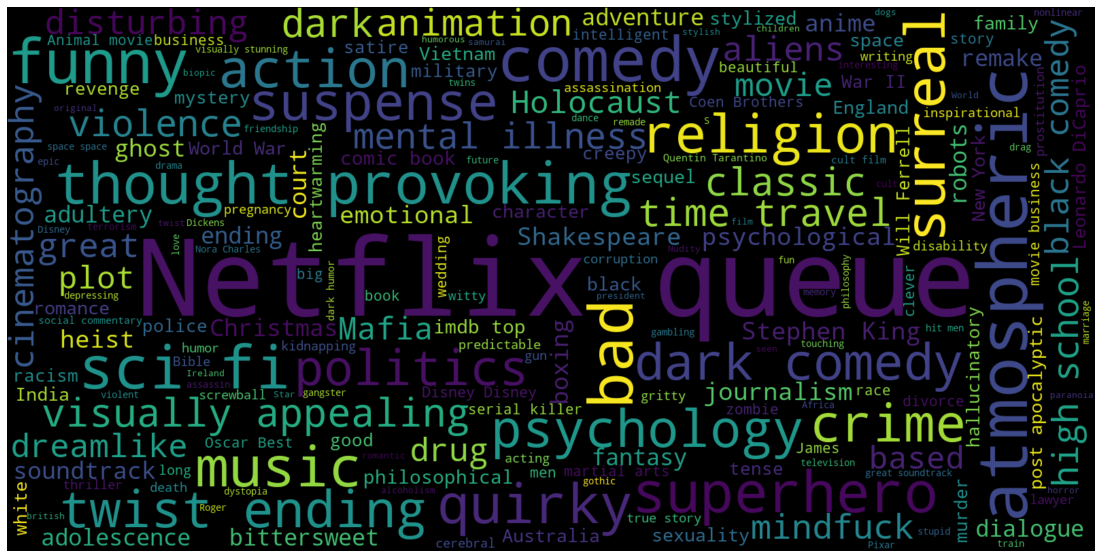

In [19]:
#creating a wordcloud of the tags for movies
tag = " ".join(i for i in df4.tag)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=1600, height=800, stopwords=stopwords).generate(tag)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

From this wordcloud can see that these are some of the top words:
- 'atmospheric'
- 'superhero'
- 'thought provoking'
- 'comedy'

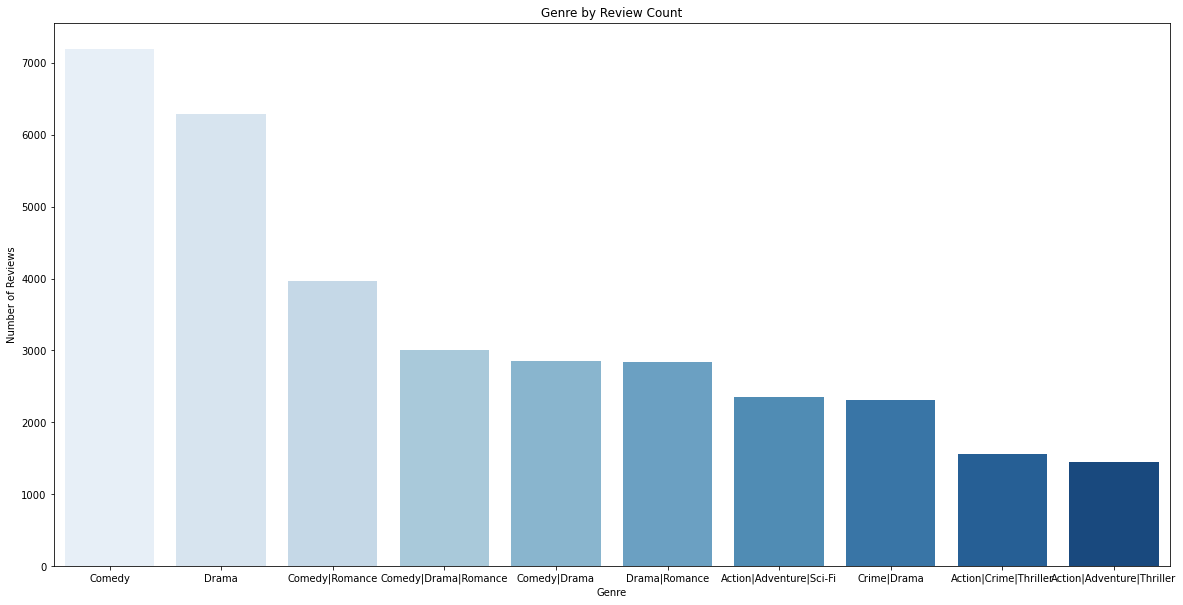

In [20]:
#plotting the 'genres' column without separation
plt.figure(figsize=(20,10))
sns.countplot(data = movie, x=movie['genres'], 
              order=movie.genres.value_counts().iloc[:10].index,
              palette='Blues')
plt.xlabel('Genre')
plt.ylabel('Number of Reviews')
plt.title('Genre by Review Count');

From this graph we can see that the genre Comedy shows up the most with over 7000 observations. It also shows up more than once with other genres; such as Romance and Drama. Drama is not far behind with 6500 observations.

In [21]:
#creating dataframe of genres that are separated 
genre_df = movie[['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
                 'Unknown']]

In [22]:
#obtaining the count of the individual genres 
genre_df.sum().sort_values(ascending=False)

Drama          41923
Comedy         39049
Action         30623
Thriller       26446
Adventure      24157
Romance        18124
Sci-Fi         17233
Crime          16679
Fantasy        11831
Children        9207
Mystery         7674
Horror          7287
Animation       6982
War             4858
IMAX            4145
Musical         4138
Western         1930
Documentary     1219
Film-Noir        870
Unknown           38
dtype: int64

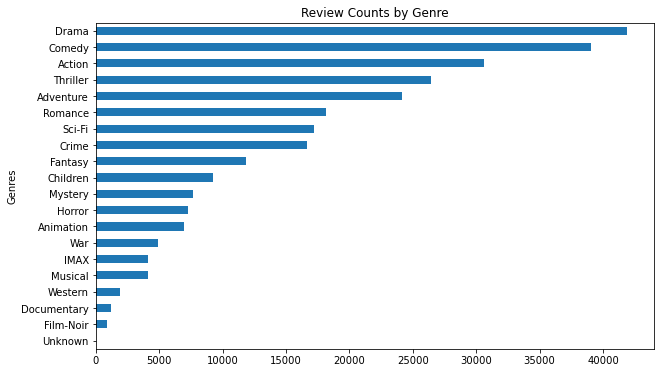

In [23]:
#plotting the genres 
genre_df.sum().sort_values(ascending=True).plot(kind='barh', figsize=(10,6), title='Review Counts by Genre', xlabel='Genres',
                                                ylabel='Number of Reviews');

As reiterated from the genre counts Drama, Comedy, Action, Thriller, and Adventure are the top 5 genres that show up the most in the dataset

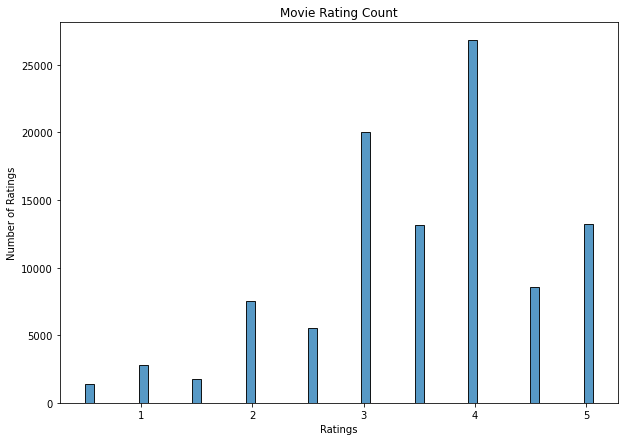

In [24]:
#plotting the rating count
plt.figure(figsize=(10,7))
sns.histplot(data=movie, x='rating', binwidth=.08)
plt.ylabel("Number of Ratings")
plt.xlabel("Ratings")
plt.title('Movie Rating Count');

From here can see the reviewers tend to rate movies more favorably with the bulk of the rating distributions being between 3 and 4. 

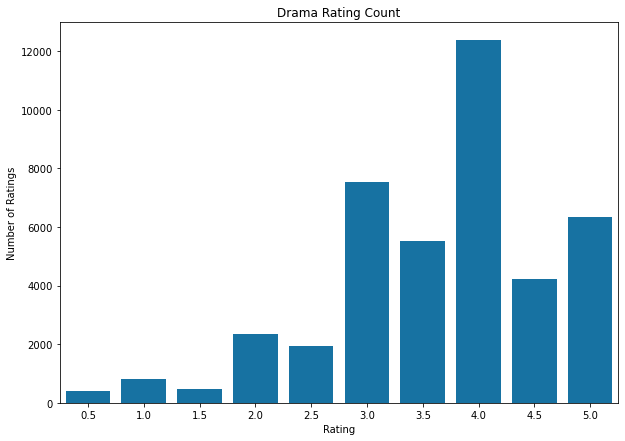

In [25]:
#creating a dataframe that only contains the Drama genre to see its distribution of ratings
drama = movie.loc[movie['Drama'] == 1]
drama['Drama'].value_counts()

#plotting the drama rating count
plt.figure(figsize=(10,7))
sns.countplot(data=drama, x='rating', color='#0079b9')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Drama Rating Count');

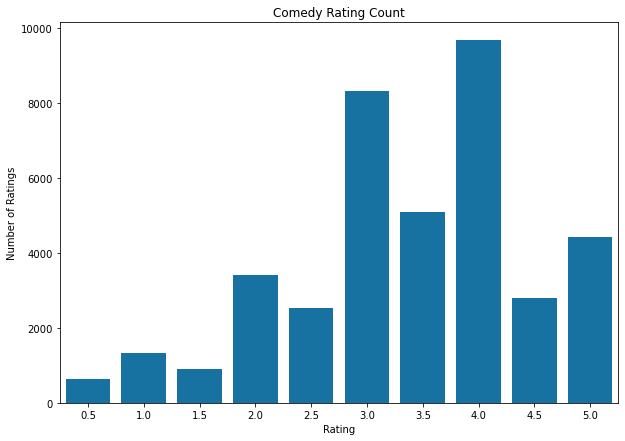

In [26]:
#creating a dataframe that only contains the Comedy genre to see its distribution of ratings
comedy = movie.loc[movie['Comedy'] == 1]
comedy['Comedy'].value_counts()

#plotting the comedy rating count
plt.figure(figsize=(10,7))
sns.countplot(data=comedy, x='rating', color='#0079b9')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Comedy Rating Count');

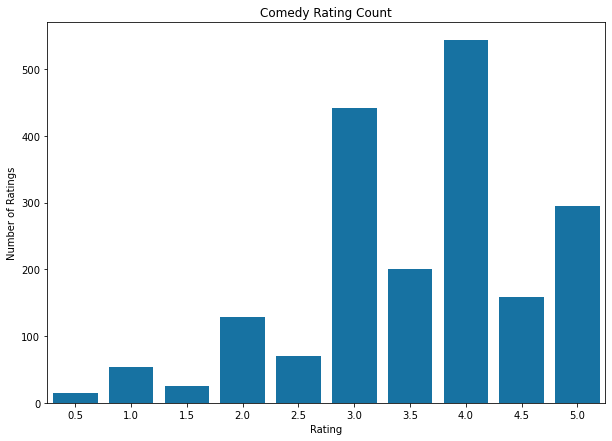

In [27]:
#creating a dataframe that only contains the Western genre to see its distribution of ratings
western = movie.loc[movie['Western'] == 1]
western['Western'].value_counts()

plt.figure(figsize=(10,7))
sns.countplot(data=western, x='rating', color='#0079b9')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Comedy Rating Count');

From the graphs of Drama, Comedy, and Western by Rating Count can see that the distribution of ratings do not change no matter if the drama is one of the most rated versus least rated. 

In [28]:
#creating a list to of super users and their count 
super_users = list(movie['userId'].value_counts().iloc[:10].index)
super_users_count = list(movie['userId'].value_counts().iloc[:10].values)

In [29]:
#value counts of users
movie['userId'].value_counts()

414    2697
599    2474
474    2108
448    1862
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: userId, Length: 610, dtype: int64

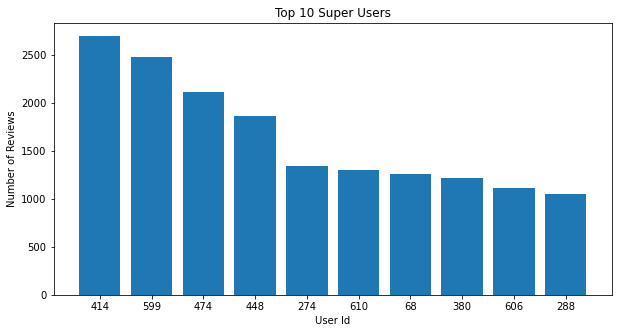

In [30]:
#plotting the top 10 users
import numpy as np
fig, ax= plt.subplots(figsize=(10, 5))

ax.set_xlabel("User Id")
ax.set_ylabel("Number of Reviews")
ax.set_title("Top 10 Super Users")

x_pos = np.arange(len(super_users))
plt.bar(x_pos, super_users_count)
plt.xticks(x_pos, super_users)

plt.show();

In [31]:
#creating a new dataframe that removes the top 5 users to see the difference between the rec systems that have them 
#versus the one that does not
rec_df = movie.drop(movie[(movie['userId'] == 414) | (movie['userId'] == 599) | (movie['userId'] == 474) | (movie['userId'] == 448) |
                         (movie['userId'] == 274)].index)

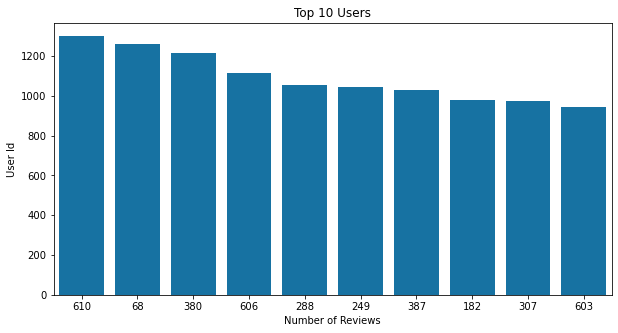

In [32]:
#plotting the top 10 users without the super users
plt.figure(figsize=(10,5))
sns.countplot(data=rec_df, x='userId', order=rec_df.userId.value_counts().iloc[:10].index, color='#0079b9')
plt.xlabel('Number of Reviews')
plt.ylabel('User Id')
plt.title('Top 10 Users');

Top reviwers are now 610 and 68 with a little over 1200 compared to user 414 that had more 2500 ratings.

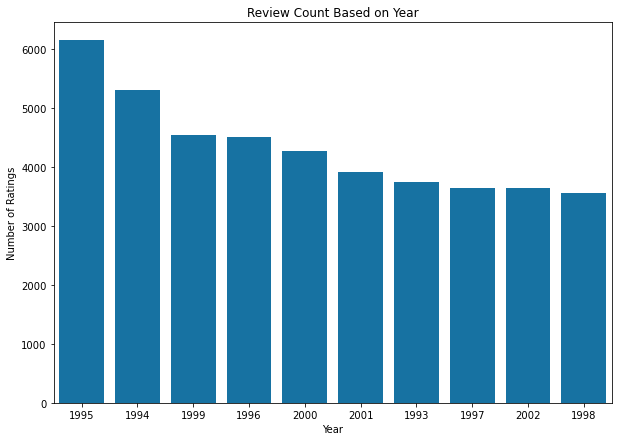

In [33]:
# Top 10 Review Count Based on Year
plt.figure(figsize=(10,7))
sns.countplot(data=movie, x='year', order=movie.year.value_counts().iloc[:10].index, color='#0079b9')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.title('Review Count Based on Year');

Here can see that most of the ratings are done of 1990s movies and early 2000s

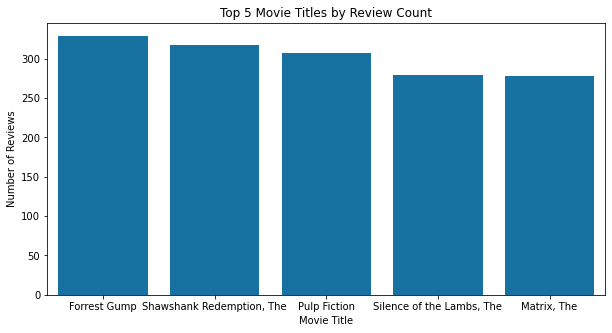

In [34]:
#top 5 movie titles 
plt.figure(figsize=(10,5))
sns.countplot(data=movie, x='title', order=movie.title.value_counts().iloc[:5].index, color='#0079b9')
plt.ylabel("Number of Reviews")
plt.xlabel("Movie Title")
plt.title("Top 5 Movie Titles by Review Count");

This graph iterates that most of the rating are on 90s movies since the top 5 are all movies that were released within that decade.

------------------------------------
## Modeling - Recommender System

In [35]:
#imports from surprise library 
from surprise import Dataset, Reader, BaselineOnly

#for splitting, training, and testing
from surprise.model_selection import cross_validate
from surprise.model_selection.split import train_test_split

#memory-based methods
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.prediction_algorithms import KNNWithZScore

#matrix factorization
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms.matrix_factorization import SVDpp, NMF

#other models 
from surprise.prediction_algorithms.slope_one import SlopeOne
from surprise.prediction_algorithms.random_pred import NormalPredictor
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.prediction_algorithms.co_clustering import CoClustering

#metric
from surprise import accuracy

In [36]:
#loading the Reader as a rating scale of 0.5 to 5
reader = Reader(rating_scale=(0.5, 5))

#loading pandas dataframe movie as a surprise dataset -- only contains the features movieId, userId, and rating
#movie contains the super users
movie_surprise = Dataset.load_from_df(movie[['userId', 'movieId', 'rating']], reader)

In [37]:
#train-test split 
train, test = train_test_split(movie_surprise, test_size=0.2, random_state=42)

In [38]:
print('Number of users: ', train.n_users)
print('Number of items: ', train.n_items)

Number of users:  610
Number of items:  8959


Getting the Number of users versus items to see if they match with movie dataframe - has super users/reviewers. They do!

### Memory-Based Methods
### Cosine Similarity - KNNBasic and KNNBaseline

In [39]:
#item to item similarity 
sim_cos_item = {'name':'cosine', 'user_based':False}

#instantiate KNNBasic
basic_cos_item = KNNBasic(sim_options=sim_cos_item)
basic_cos_item.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [40]:
#getting predictions
predictions_cos_item = basic_cos_item.test(test)
print(accuracy.rmse(predictions_cos_item))

RMSE: 0.9720
0.9720337803647293


In [41]:
#user to user similarity
sim_cos_user = {'name':'cosine', 'user_based':True}

#instantiate KNNBasic
basic_cos_user = KNNBasic(sim_options=sim_cos_user)
basic_cos_user.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [42]:
#getting predictions
predictions_cos_user = basic_cos_user.test(test)
print(accuracy.rmse(predictions_cos_user))

RMSE: 0.9672
0.9671630935763456


In [43]:
#item to item similarity 
sim_cos_baseline = {'name':'cosine', 'user_based':False}

#instantiate KNNBaseline
knn_baseline_cos = KNNBaseline(sim_options=sim_cos_baseline)
knn_baseline_cos.fit(train)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [44]:
#getting predictions
predictions_baseline_cos = knn_baseline_cos.test(test)
print(accuracy.rmse(predictions_baseline_cos))

RMSE: 0.8859
0.8858612340316458


In [45]:
#user to user similarity KNNBaseline
sim_cos_baseline_u = {'name':'cosine', 'user_based':True}

#instantiate KNNBaseline
knn_baseline_cos_u = KNNBaseline(sim_options=sim_cos_baseline_u)
knn_baseline_cos_u.fit(train)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [46]:
#getting predictions
predictions_baseline_cos_u = knn_baseline_cos_u.test(test)
print(accuracy.rmse(predictions_baseline_cos_u))

RMSE: 0.8774
0.8774295469777899


### Pearson Similarity - KNNBasic, KNNWithMeans, and KNNBaseline

In [47]:
#item to item similarity 
sim_pearson = {'name':'pearson', 'user_based':False}

#instantiate KNNBasic
knn_basic_p = KNNBasic(sim_options=sim_pearson)
knn_basic_p.fit(train)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [48]:
#getting predictions
predictions_basic = knn_basic_p.test(test)
print(accuracy.rmse(predictions_basic))

RMSE: 0.9684
0.9683632287059404


In [49]:
#item to item similarity 
sim_pearson_means = {'name':'pearson', 'user_based':False}

#instantiate KNNWithMeans
knn_means = KNNWithMeans(sim_options=sim_pearson_means)
knn_means.fit(train)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [50]:
#getting predictions
predictions_means = knn_means.test(test)
print(accuracy.rmse(predictions_means))

RMSE: 0.8974
0.8974282632075296


In [51]:
#item to item similarity 
sim_pearson_baseline_i = {'name':'pearson', 'user_based':False}

#instantiate KNNBaseline
knn_baseline_i = KNNBaseline(sim_options=sim_pearson_baseline_i)
knn_baseline_i.fit(train)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [52]:
#getting predictions
predictions_baseline_i = knn_baseline_i.test(test)
print(accuracy.rmse(predictions_baseline_i))

RMSE: 0.8787
0.8786940038898103


In [53]:
#user to user similarity
sim_pearson_baseline_u = {'name':'pearson', 'user_based':True}

#instantiate KNNBaseline
knn_baseline_u = KNNBaseline(sim_options=sim_pearson_baseline_u)
knn_baseline_u.fit(train)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [54]:
#getting predictions
predictions_baseline_u = knn_baseline_u.test(test)
print(accuracy.rmse(predictions_baseline_u))

RMSE: 0.8765
0.8764533073556253


KNNBaseline performs the best in terms of cosine and pearson similarity in user to user similarity:
- Cosine accuracy RMSE score: 87.77684214621624
- Pearson accuracy RMSE score: 87.65853912880508

## Model-Based Methods - SVD++, NMF and others

- SlopeOne
- NormalPredictors
- KNNWithZScore
- BaselineOnly
- CoClustering

In [55]:
#seeing which models out of all the above would give the best RMSE value 

#benchmark = []
# Iterate over all algorithms
#for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    #results = cross_validate(algorithm, movie_surprise, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    #tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    #tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    #benchmark.append(tmp)
    
#pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

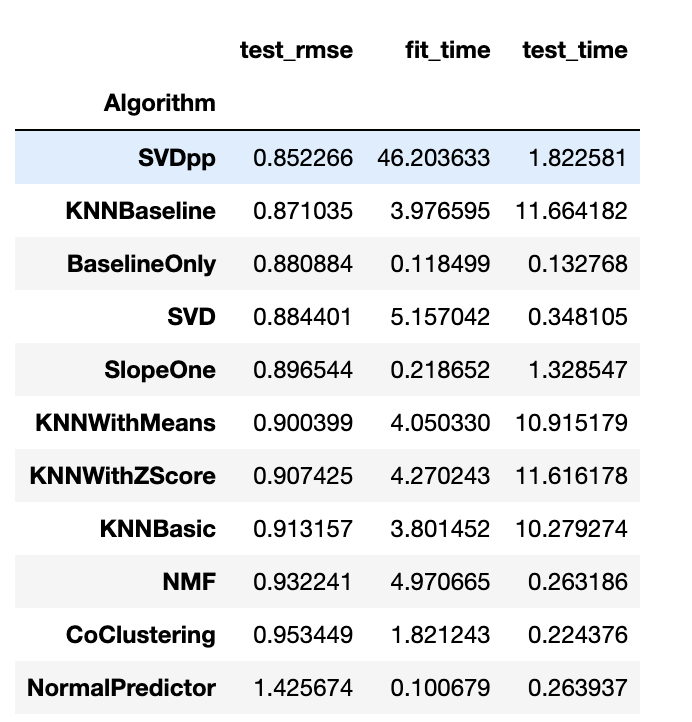

-----
## Final Recommendation System with Super Users

In [56]:
#final model with super users
model = SVDpp(random_state=42)
results = cross_validate(model, movie_surprise, measures=['RMSE'], cv=3, verbose=False)

In [57]:
results

{'test_rmse': array([0.86994223, 0.87018693, 0.86967141]),
 'fit_time': (257.40580773353577, 254.59464812278748, 255.19213223457336),
 'test_time': (7.619609117507935, 7.986412048339844, 7.87883186340332)}

In [58]:
#predicting user 10 with movieId 30
model.fit(train)
model.predict(10, 30)

Prediction(uid=10, iid=30, r_ui=None, est=3.0789648552497364, details={'was_impossible': False})

### Cold Start Solution

In [62]:
def movie_rater(movie_df, num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 0-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID, 'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list   

In [63]:
#creating new dataframe and keeping only the movieId, title, and genres columns
rater_df = movie.drop(columns=['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 
                    'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
                    'War', 'Western', 'Unknown', 'timestamp', 'userId', 'rating', 'year'], axis=1)

In [64]:
user_rating = movie_rater(rater_df, 4, 'Comedy')

       movieId               title          genres
28975     1278  Young Frankenstein  Comedy|Fantasy
How do you rate this movie on a scale of 0-5, press n if you have not seen :
3
       movieId                 title                genres
70098     6218  Bend It Like Beckham  Comedy|Drama|Romance
How do you rate this movie on a scale of 0-5, press n if you have not seen :
4
      movieId   title         genres
6812      256  Junior  Comedy|Sci-Fi
How do you rate this movie on a scale of 0-5, press n if you have not seen :
2
       movieId      title                       genres
10807      367  Mask, The  Action|Comedy|Crime|Fantasy
How do you rate this movie on a scale of 0-5, press n if you have not seen :
5


In [65]:
#creating new dataframe that only contains the following:
predict_df = movie[['userId', 'movieId', 'rating']]
predict_df.head()

,userId,movieId,rating
0,1,1,4.0
1,5,1,4.0
2,7,1,4.5
3,15,1,2.5
4,17,1,4.5


In [66]:
#creating a dictionary of the above movies 
user_rating = [{'userId': 1000, 'movieId': 7381, 'rating': 4},
              {'userId': 1000, 'movieId': 2296, 'rating': 3},
              {'userId': 1000, 'movieId': 2657, 'rating': 2},
              {'userId': 1000, 'movieId': 2294, 'rating': 3.5},
              {'userId': 1000, 'movieId': 4299, 'rating': 5}, 
              {'userId': 1000, 'movieId': 2828, 'rating': 3},
              {'userId': 1000, 'movieId': 46578, 'rating': 4},
              {'userId': 1000, 'movieId': 2383, 'rating': 1}, 
              {'userId': 1000, 'movieId': 2324, 'rating': 4},
              {'userId': 1000, 'movieId': 2683, 'rating': 4},
              {'userId': 1000, 'movieId': 118834, 'rating': 2.5},
              {'userId': 1000, 'movieId': 745, 'rating': 5},
              {'userId': 1000, 'movieId': 5296, 'rating': 4},
              {'userId': 1000, 'movieId': 71156, 'rating': 3.5},
              {'userId': 1000, 'movieId': 4016, 'rating': 5},
              {'userId': 1000, 'movieId': 68848, 'rating': 3},
              {'userId': 1000, 'movieId': 2797, 'rating': 5},
              {'userId': 1000, 'movieId': 1265, 'rating': 5},
              {'userId': 1000, 'movieId': 1566, 'rating': 5},
              {'userId': 1000, 'movieId': 4141, 'rating': 4},
              {'userId': 1000, 'movieId': 6464, 'rating': 4},
              {'userId': 1000, 'movieId': 3868, 'rating': 5},
              {'userId': 1000, 'movieId': 3882, 'rating': 4},
              {'userId': 1000, 'movieId': 3175, 'rating': 5}]

## Making Predictions for User 1000

In [67]:
## add the new ratings to the original ratings DataFrame
new_ratings_df = predict_df.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [68]:
#making sure user 1000 is added
new_ratings_df.loc[new_ratings_df['userId'] == 1000]

,userId,movieId,rating
100806,1000,7381,4.0
100807,1000,2296,3.0
100808,1000,2657,2.0
100809,1000,2294,3.5
100810,1000,4299,5.0
100811,1000,2828,3.0
100812,1000,46578,4.0
100813,1000,2383,1.0
100814,1000,2324,4.0
100815,1000,2683,4.0


In [69]:
#instantiaing and fitting SVD++ model of the trainset
SVDpp_ = SVDpp(random_state=42)
SVDpp_.fit(new_data.build_full_trainset())

In [70]:
#creating list of movies to get a ranking
list_of_movies = []
for m_id in new_ratings_df['movieId'].unique():
    list_of_movies.append((m_id,SVDpp_.predict(10,m_id)[3]))

In [71]:
#sorting the list of movies
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [72]:
# return the top n recommendations using the user rating that was inputted
def recommended_movies(user_ratings, movie_title_df, n):
    for idx, rec in enumerate(user_ratings):
        title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
        print('Recommendation # ', idx+1, ': ', title, '\n')
        n-= 1
        if n == 0:
            break
            
recommended_movies(ranked_movies, df1, 5)

Recommendation #  1 :  1486    Back to the Future Part II (1989)
Name: title, dtype: object 

Recommendation #  2 :  1059    Star Trek IV: The Voyage Home (1986)
Name: title, dtype: object 

Recommendation #  3 :  1940    10 Things I Hate About You (1999)
Name: title, dtype: object 

Recommendation #  4 :  1823    Christmas Vacation (National Lampoon's Christm...
Name: title, dtype: object 

Recommendation #  5 :  9006    The Intern (2015)
Name: title, dtype: object 



-------
## Final Recommendation System Without Super Users

In [73]:
#using rec_df - without super users
display(rec_df.head())
display(rec_df['userId'].value_counts())

,movieId,title,genres,userId,rating,timestamp,year,Action,Adventure,Animation,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,Unknown,War,Western
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,1995,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1995,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,1995,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,1995,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,1995,0,1,1,...,0,0,0,0,0,0,0,0,0,0


610    1301
68     1260
380    1214
606    1115
288    1055
       ... 
431      20
257      20
194      20
569      20
53       20
Name: userId, Length: 605, dtype: int64

In [74]:
#loading the Reader as a rating scale of 0.5 to 5
reader_ns = Reader(rating_scale=(0.5, 5))

#loading pandas dataframe rec_df as a surprise dataset -- only contains the features movieId, userId, and rating
#movie contains the super users
no_supers = Dataset.load_from_df(rec_df[['movieId', 'userId', 'rating']], reader_ns)

In [75]:
#train test split
train_no_supers, test_no_supers = train_test_split(no_supers, test_size=0.2, random_state=42)

In [76]:
#instantiating model 
model_no_supers = SVDpp(random_state=42)
results_no_supers = cross_validate(model_no_supers, no_supers, measures=['RMSE'], cv=3, verbose=False)

In [77]:
#results
results_no_supers

{'test_rmse': array([0.86505432, 0.87060582, 0.86290809]),
 'fit_time': (25.637144088745117, 25.66705083847046, 25.781039237976074),
 'test_time': (1.1389377117156982, 0.9564628601074219, 1.0596528053283691)}

The RMSE actually got worse without super users but this makes sense since we ended dropping observation. However the diffrence is not too bad since it is about .86 to .85 with those super users.

In [78]:
#predicting user 1 and movieId 1 
model_no_supers.predict(1, 1)

Prediction(uid=1, iid=1, r_ui=None, est=4.545860976108006, details={'was_impossible': False})

Prediction of Toy Story was about a 4.5 when in actuality user 1 rated a 4. This is within our margin of error. 

In [79]:
#creating a df with only userId, movieId, and rating
rater_df_no_supers = rec_df[['userId', 'movieId', 'rating']]

#sanity check
rater_df_no_supers.head()

,userId,movieId,rating
0,1,1,4.0
1,5,1,4.0
2,7,1,4.5
3,15,1,2.5
4,17,1,4.5


In [80]:
#add the new ratings to the original ratings DataFrame
new_ratings_df_no_supers = rater_df_no_supers.append(user_rating,ignore_index=True)
new_data_no_supers = Dataset.load_from_df(new_ratings_df_no_supers,reader)

In [81]:
#instantiaing and fitting SVD++ model of the trainset
SVDpp_ns = SVDpp(random_state=42)
SVDpp_ns.fit(new_data_no_supers.build_full_trainset())

In [82]:
#creating list of movies to get a ranking
list_of_movies_ns = []
for m_id in rater_df_no_supers['movieId'].unique():
    list_of_movies_ns.append((m_id,SVDpp_ns.predict(1000, m_id)[3]))

In [83]:
#sorting the list of movies
ranked_movies_ns = sorted(list_of_movies_ns, key=lambda x:x[1], reverse=True)

In [84]:
#recommendations
recommended_movies(ranked_movies_ns, df1, 10)

Recommendation #  1 :  277    Shawshank Redemption, The (1994)
Name: title, dtype: object 

Recommendation #  2 :  2582    Guess Who's Coming to Dinner (1967)
Name: title, dtype: object 

Recommendation #  3 :  4025    Grave of the Fireflies (Hotaru no haka) (1988)
Name: title, dtype: object 

Recommendation #  4 :  704    Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
Name: title, dtype: object 

Recommendation #  5 :  937    Seventh Seal, The (Sjunde inseglet, Det) (1957)
Name: title, dtype: object 

Recommendation #  6 :  2963    Legend of Drunken Master, The (Jui kuen II) (1...
Name: title, dtype: object 

Recommendation #  7 :  8301    Day of the Doctor, The (2013)
Name: title, dtype: object 

Recommendation #  8 :  841    Streetcar Named Desire, A (1951)
Name: title, dtype: object 

Recommendation #  9 :  686    Rear Window (1954)
Name: title, dtype: object 

Recommendation #  10 :  46    Usual Suspects, The (1995)
Name: title, dtype: object 



-------
## Conclusion
Overall, we recommend that Paramount + focus their efforts on developing a SVD++ model, with having new users enter their personal ratings for 10+ movies, and to focus their I.P acquisitions on the top 5 genres that users interact with the most.